In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
# 加载LibSVM格式数据模块
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')

!pwd
!ls -a ./raw

/Users/hobee/PythonScript/CCF-BDCI-2022-FXFZ
.                    dataA.csv            dataTrain.csv
..                   dataNoLabel.csv      submit_example_A.csv


In [18]:
!pip3 install sklearn

In [19]:
raw_data = pd.read_csv("./raw/dataTrain.csv")

raw_data.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f38,f39,f40,f41,f42,f43,f44,f45,f46,label
0,81167,0,1,mid,0,0,0,153,0,0,...,0,0,0,0,0,0,0,624,1539,0
1,50408,1,1,mid,0,0,21,0,0,0,...,0,0,0,0,0,0,0,186,366,0
2,9114,0,0,high,36,36,120,0,0,0,...,0,0,0,0,0,0,0,24,48,1
3,53228,1,1,low,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,9,0
4,56280,1,1,mid,9,51,294,0,0,0,...,0,0,0,0,0,0,0,42,141,0


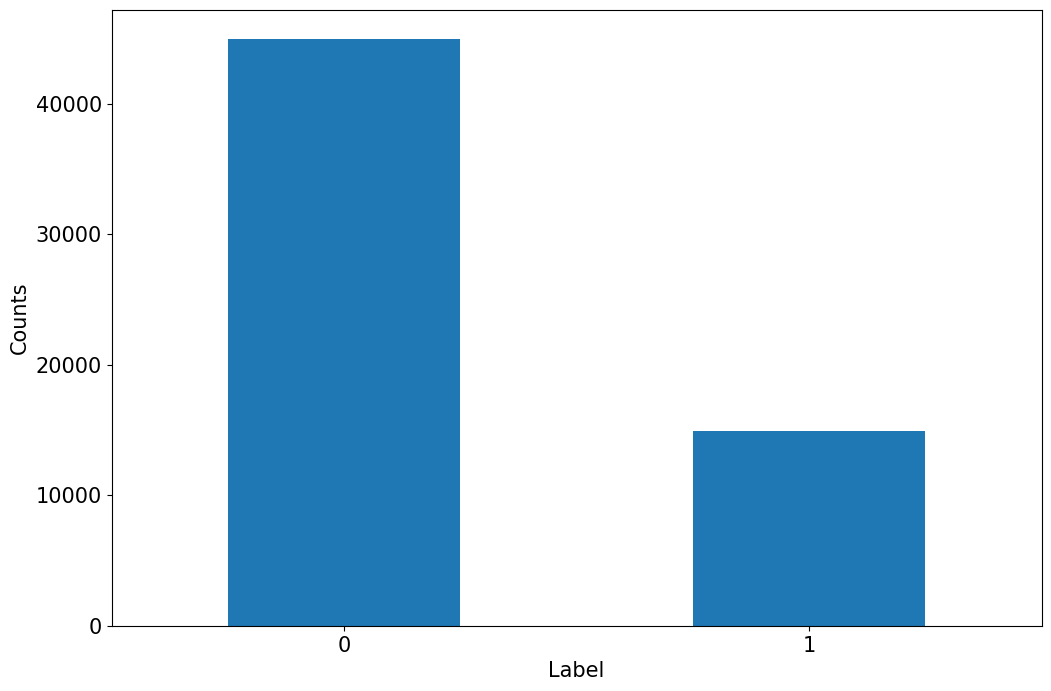

In [20]:
# label 分布情况
ax = raw_data['label'].value_counts().plot(kind = 'bar',figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Label',fontsize = 15)
plt.show()

In [21]:
def data_pre_process(raw,is_train=True):
    data = raw.copy()
    data["f3"] = raw["f3"].map({'low': 0, 'mid': 1, 'high': 2})
    label = None
    
    # 暴力Feature 位置
    loc_f = ['f1', 'f2', 'f4', 'f5', 'f6']
    for i in range(len(loc_f)):
        for j in range(i + 1, len(loc_f)):
            data[f'{loc_f[i]}+{loc_f[j]}'] = data[loc_f[i]] + data[loc_f[j]]
            data[f'{loc_f[i]}-{loc_f[j]}'] = data[loc_f[i]] - data[loc_f[j]]
            data[f'{loc_f[i]}*{loc_f[j]}'] = data[loc_f[i]] * data[loc_f[j]]
            data[f'{loc_f[i]}/{loc_f[j]}'] = data[loc_f[i]] / data[loc_f[j]]
            
    # 暴力Feature 通话
    com_f = ['f43', 'f44', 'f45', 'f46']
    for i in range(len(com_f)):
        for j in range(i + 1, len(com_f)):
            data[f'{com_f[i]}+{com_f[j]}'] = data[com_f[i]] + data[com_f[j]]
            data[f'{com_f[i]}-{com_f[j]}'] = data[com_f[i]] - data[com_f[j]]
            data[f'{com_f[i]}*{com_f[j]}'] = data[com_f[i]] * data[com_f[j]]
            data[f'{com_f[i]}/{com_f[j]}'] = data[com_f[i]] / data[com_f[j]]
            
    # 离散化            
    all_f = [f'f{idx}' for idx in range(1, 47) if idx != 3]
    for col in all_f:
        data[f'{col}_log'] = data[col].apply(lambda x: int(np.log(x)) if x > 0 else 0)

    # 特征交叉        
    log_f = [f'f{idx}_log' for idx in range(1, 47) if idx != 3]
    for i in range(len(log_f)):
        for j in range(i + 1, len(log_f)):
            data[f'{log_f[i]}_{log_f[j]}'] = data[log_f[i]]*10000 + data[log_f[j]]
    
    data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    if is_train:
        label = data["label"]
        del data["label"]
    del data["id"]
    
    return data,label

data,data_label = data_pre_process(raw_data)
data = data[:50000]
data_label = data_label[:50000]

data.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f42_log_f43_log,f42_log_f44_log,f42_log_f45_log,f42_log_f46_log,f43_log_f44_log,f43_log_f45_log,f43_log_f46_log,f44_log_f45_log,f44_log_f46_log,f45_log_f46_log
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.306280,0.687180,1.012940,6.006540,18.33246,37.031040,18.502440,6.696360,0.856500,1.262340,...,180.95932,181.450580,183.609780,184.561340,7594.450580,7596.609780,7597.561340,12509.209780,12510.161340,34102.161340
std,0.460952,0.463646,0.817353,14.969066,32.85189,56.319464,46.457007,30.548644,9.672531,12.064897,...,2518.29751,2518.316344,2518.338602,2518.345414,12695.826966,12695.442519,12695.462829,16492.535044,16492.629319,20493.268121
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,2.000000,3.000000,0.000000,2.000000,3.000000,2.000000,3.000000,20003.000000
50%,0.000000,1.000000,1.000000,0.000000,0.00000,9.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,4.000000,5.000000,0.000000,4.000000,5.000000,5.000000,6.000000,40005.000000
75%,1.000000,1.000000,2.000000,0.000000,27.00000,57.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,2.000000,5.000000,6.000000,10002.000000,10005.000000,10006.000000,20006.000000,20007.000000,50006.000000
max,1.000000,1.000000,2.000000,267.000000,744.00000,1365.000000,273.000000,264.000000,162.000000,237.000000,...,50003.00000,50005.000000,50007.000000,50009.000000,80009.000000,80008.000000,80009.000000,90008.000000,90009.000000,90010.000000


In [22]:
#分类器使用 xgboost
clf1 = xgb.XGBClassifier(learning_rate=0.1,
                      n_estimators=100,            # 树的个数--100棵树建立xgboost
                      max_depth=6,                 # 树的深度
                      min_child_weight = 1,        # 叶子节点最小权重
                      gamma=0.,                    # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,               # 随机选择80%样本建立决策树
                      colsample_btree=0.8,         # 随机选择80%特征建立决策树
                      objective='binary:logistic', # 指定损失函数
                      scale_pos_weight=1,          # 解决样本个数不平衡的问题
                      random_state=27              # 随机数
                      )
 
#设定搜索的xgboost参数搜索范围，值搜索XGBoost的主要6个参数
param_dist = {
'n_estimators':range(80,200,4),
'max_depth':range(2,15,1),
'learning_rate':np.linspace(0.01,2,20),
'subsample':np.linspace(0.7,0.9,20),
'colsample_bytree':np.linspace(0.5,0.98,10),
'min_child_weight':range(1,9,1)
}
 
#RandomizedSearchCV参数说明，clf1设置训练的学习器
#param_dist字典类型，放入参数搜索范围
#scoring = 'neg_log_loss'，精度评价方式设定为“neg_log_loss“
#n_iter=300，训练300次，数值越大，获得的参数精度越大，但是搜索时间越长
#n_jobs = -1，使用所有的CPU进行训练，默认为1，使用1个CPU
grid = RandomizedSearchCV(clf1,param_dist,cv = 3,scoring = 'auc',n_iter=300,n_jobs = -1)
 
'''
#在训练集上训练
grid.fit(data,data_label) #TODO : 这里把训练停了
#返回最优的训练器
best_estimator = grid.best_estimator_
print(best_estimator)
#输出最优训练器的精度
print(grid.best_score_)
'''

'\n#在训练集上训练\ngrid.fit(data,data_label) #TODO : 这里把训练停了\n#返回最优的训练器\nbest_estimator = grid.best_estimator_\nprint(best_estimator)\n#输出最优训练器的精度\nprint(grid.best_score_)\n'

In [34]:
gbc = GradientBoostingClassifier(
    n_estimators=50, 
    learning_rate=0.1,
    max_depth=5
)
hgbc = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5
)
xgbc = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=100, 
    max_depth=6, 
    learning_rate=0.1
)
cbc = CatBoostClassifier(
    iterations=210, 
    depth=6, 
    learning_rate=0.03, 
    l2_leaf_reg=1, 
    loss_function='Logloss', 
    verbose=0
)
estimators = [
    ('gbc', gbc),
    ('hgbc', hgbc),
    ('xgbc', xgbc),
    ('cbc', cbc)
]
clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression()
)





In [36]:
def train_model(x,y, model=None):
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2,random_state = 33)
    ### 训练模型
    if model == None:
        model = xgb.XGBClassifier(learning_rate=0.1,
                      n_estimators=100,            # 树的个数--100棵树建立xgboost
                      max_depth=6,                 # 树的深度
                      min_child_weight = 1,        # 叶子节点最小权重
                      gamma=0.,                    # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,               # 随机选择80%样本建立决策树
                      colsample_btree=0.8,         # 随机选择80%特征建立决策树
                      objective='binary:logistic', # 指定损失函数
                      scale_pos_weight=1,          # 解决样本个数不平衡的问题
                      random_state=27              # 随机数
                      )

    # 拟合
    # model.fit(x_train, y_train, eval_set = [(x_test,y_test)], eval_metric = "auc", early_stopping_rounds = 10,verbose = True)
    model.fit(x_train, y_train)
    
    return model,x_train,x_test,y_train,y_test

model,x_train,x_test,y_train,y_test = train_model(data,data_label,clf)
model

StackingClassifier(estimators=[('gbc',
                                GradientBoostingClassifier(max_depth=5,
                                                           n_estimators=50)),
                               ('hgbc',
                                HistGradientBoostingClassifier(max_depth=5)),
                               ('xgbc',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc'...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None,
                                              reg_alpha=None, reg_lambda=None, ...)),
                               ('cbc',
                                <catboost.core.CatBoostClassifier object at 0x2863813f0>)],
                   final_estimator=LogisticRegression())

In [44]:
# save model
import pickle
with open("./models/stack_model.pkl", "wb") as file:
    pickle.dump(model,file=file)

model = pickle.load(open("./models/stack_model.pkl", "rb"))

In [37]:
# 查看训练模型准确度
def show_auc(x,y,model):
    pred_label = model.predict(x)
    pred_prob = model.predict_proba(x)
    acc = accuracy_score(y, pred_label)
    precision = precision_score(y, pred_label)
    recall = recall_score(y, pred_label)
    auc = roc_auc_score(y, pred_label) # 标签计算
    fpr,tpr,threshold=roc_curve(y,pred_prob[:,1],pos_label=1)
    auc_all = roc_auc_score(y, pred_prob[:,1]) # 按概率计算
    print("===="*8)
    print("Summary:")
    print(f"acc: {acc}\nrecall: {recall}\nauc: {auc}\nfull_auc: {auc_all}")
    print("===="*8)
    print()

show_auc(x_train, y_train, model)
show_auc(x_test, y_test, model)
show_auc(data,data_label,model)

Summary:
acc: 0.881225
recall: 0.6386681420380244
auc: 0.8000553192308623
full_auc: 0.9270421726584668

Summary:
acc: 0.8623
recall: 0.6014234875444839
auc: 0.7760162545472385
full_auc: 0.9073836522705244

Summary:
acc: 0.87744
recall: 0.6311146752205292
auc: 0.7952002899150874
full_auc: 0.9230929012470324



In [25]:
# 半监督
raw_semi = pd.read_csv("./raw/dataNoLabel.csv")
data_semi,_ = data_pre_process(raw_semi,is_train=False)

pred_label_semi = model.predict(data_semi)
# data_semi["label"] = pred_label_semi

data_semi

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f42_log_f43_log,f42_log_f44_log,f42_log_f45_log,f42_log_f46_log,f43_log_f44_log,f43_log_f45_log,f43_log_f46_log,f44_log_f45_log,f44_log_f46_log,f45_log_f46_log
0,0,1,1,0,0,0,0,0,0,0,...,0,2,5,6,2,5,6,20005,20006,50006
1,1,1,1,0,0,0,0,0,0,0,...,2,4,6,7,20004,20006,20007,40006,40007,60007
2,0,1,0,0,0,0,0,0,0,0,...,0,0,3,4,0,3,4,3,4,30004
3,1,1,1,0,0,0,0,0,0,0,...,0,0,3,3,0,3,3,3,3,30003
4,1,1,0,0,0,0,0,0,0,0,...,0,0,5,6,0,5,6,5,6,50006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39879,0,0,1,0,0,54,0,0,0,0,...,3,4,5,6,30004,30005,30006,40005,40006,50006
39880,0,1,0,144,198,594,0,0,0,0,...,5,5,7,8,50005,50007,50008,50007,50008,70008
39881,0,1,0,0,0,0,0,0,0,0,...,2,2,6,7,20002,20006,20007,20006,20007,60007
39882,0,1,0,0,0,0,0,0,0,0,...,0,0,5,6,0,5,6,5,6,50006


In [26]:
# 加入之后重新训练
data_semi_concat = pd.concat([data, data_semi]).reset_index(drop=True)
label_semi_concat = np.append(data_label,pred_label_semi)

model_semi,x_semi_train,x_semi_test,y_semi_train,y_semi_test = train_model(data_semi_concat,label_semi_concat)

[21:39:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "colsample_btree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.93571
[1]	validation_0-auc:0.93746
[2]	validation_0-auc:0.93745
[3]	validation_0-auc:0.93897
[4]	validation_0-auc:0.93963
[5]	validation_0-auc:0.94001
[6]	validation_0-auc:0.94035
[7]	validation_0-auc:0.94065
[8]	validation_0-auc:0.94122
[9]	validation_0-auc:0.94127
[10]	validation_0-auc:0.94144
[11]	validation_0-auc:0.94152
[12]	validation_0-auc:0.94179
[13]	validation_0-auc:0.94178
[14]	validation_0-auc:0.94205
[15]	validation_0-auc:0.94248
[16]	validation_0-auc:0.94251
[17]	validation_0-auc:0.94280
[18]	vali

In [27]:
show_auc(x_train, y_train, model_semi)
show_auc(x_test, y_test, model_semi)
show_auc(data,data_label,model_semi)

Summary:
acc: 0.88065
recall: 0.6455085001508902
auc: 0.8019618085437906
full_auc: 0.924386469410682

Summary:
acc: 0.8718
recall: 0.6334519572953736
auc: 0.7929674456534423
full_auc: 0.9194988250072417

Summary:
acc: 0.87888
recall: 0.6430633520449078
auc: 0.8001487823374019
full_auc: 0.9234092010006001



In [40]:
# 测试提交
raw_A = pd.read_csv("./raw/dataA.csv")
data_A,_ = data_pre_process(raw_A,is_train=False)

print(data_A.head())

# pred_label_A = model_semi.predict(data_A)
pred_label_A = model.predict(data_A)
pred_label_A

   f1  f2  f3  f4  f5  f6  f7  f8  f9  f10  ...  f42_log_f43_log  \
0   1   1   1   0   0   0   0   0   0    0  ...                0   
1   0   1   1   0   0   0   0   0   0    0  ...                1   
2   0   1   2   0   0   0   0   0   0    0  ...                0   
3   0   1   1   0   0   0   0   0   0    0  ...                0   
4   1   1   0   0   0   0   0   0   0    0  ...                0   

   f42_log_f44_log  f42_log_f45_log  f42_log_f46_log  f43_log_f44_log  \
0                1                3                5                1   
1                3                5                6            10003   
2                0                2                3                0   
3                0                2                2                0   
4                0                4                5                0   

   f43_log_f45_log  f43_log_f46_log  f44_log_f45_log  f44_log_f46_log  \
0                3                5            10003            10005   
1     

array([0, 0, 0, ..., 0, 1, 0])

In [42]:
#修正概率为0.3
# pred_prob_A = model_semi.predict_proba(data_A)[:,1]
pred_prob_A = model.predict_proba(data_A)[:,1]
pred_label_A_fix = pd.DataFrame([1 if i >= 0.3 else 0 for i in pred_prob_A])
pred_label_A_fix.value_counts()

0    41548
1     8310
dtype: int64

In [43]:
def save_label(data_id,label):
    df = pd.DataFrame({'id':data_id,'label':label})
    df.to_csv("./res/s.csv",index=False)

save_label(list(raw_A['id']),list(pred_prob_A))

In [31]:
!pwd

/Users/hobee/PythonScript/CCF-BDCI-2022-FXFZ
